# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [3]:
!pip install gym

In [4]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [5]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [6]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [7]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(17, 10, False)
(20, 10, False)
End game! Reward:  1.0
You won :)

(19, 7, False)
End game! Reward:  1.0
You won :)

(19, 8, False)
(21, 8, False)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [8]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [9]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((20, 1, False), 0, -1.0)]
[((21, 10, True), 0, 1.0)]
[((18, 10, False), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [10]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env)
        # my version was very wrong, mostly because of issues with transforming the data structures, 
        # this is the solution recommended by the course, with annotations
        
        # obtain the states, actions, and rewards
        # first we zip all the elements of the tuples together in a structure
        # then we unpack them into their variables
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        # in this exercise, gamma is 1 so this is just for demonstration, but this MC prediction algorithm woudl still work
        # if we were discounting
        # so i will an incrementing integer and that will be the exponent that gamma is raised to at each time step. cool. 
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            """ This is where I was most confused before. besides zipping the tuples first, this part where you use the index of the 
                episode to determine which action to look up instead of trying to unpack the states and actions both from episodes. 
                For some reason I thought that the episodes was some kind of 2D dict and I got stuck there, this way, with them all
                separate and the index tying them together works better. """
            # note to self, the indexing for discounts, you are getting everything starting with the end up to but not including
            # the current timestep. 
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            # shouldn't this be unindented? wouldn't we want to do it after iterating all the episodes for fewer calculations?
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 5000000/5000000.

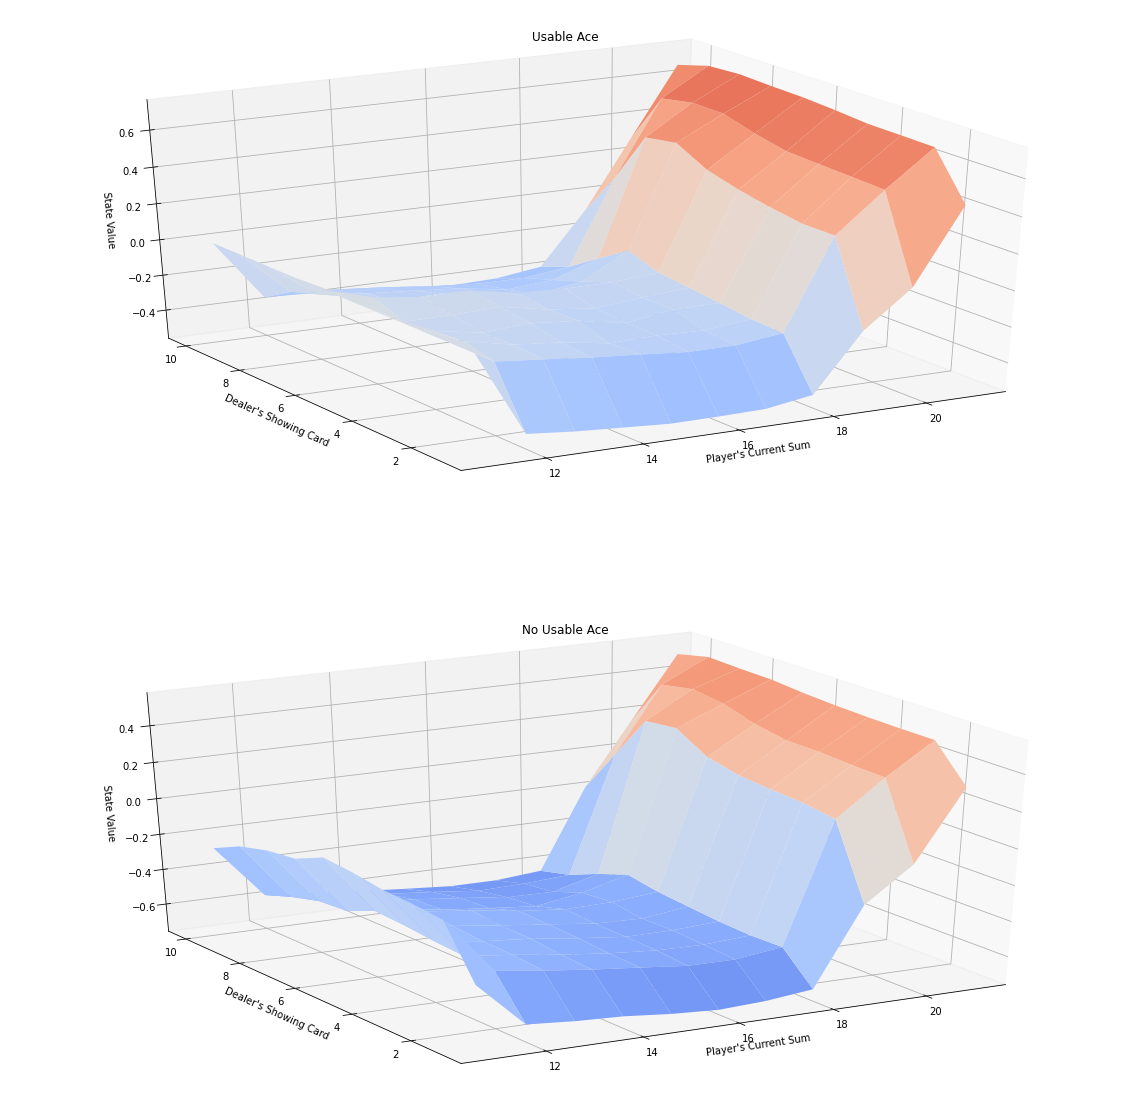

In [11]:
# obtain the action-value function
#Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)
Q = mc_prediction_q(env, 5000000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [26]:
def generate_episode(bj_env, policy):
    episode = []
    state = bj_env.reset()
    while True:        
        action = policy(state) 
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode
""" probability step funciton, tell me whether I'm greedy or not. num actions is hardcoded"""
def is_greedy(epsilon):
    num_actions = 2
    # as mentined in lecture, generate a random number between 0 and 1, if it is outside of epsilon probability, 
    # choose the optimal action in the Q table, otherwise, choose an action at random
    chance_of_greedy = [epsilon / num_actions, 1 - epsilon + epsilon / num_actions]
    return np.random.choice(np.arange(2), p=chance_of_greedy)

""" takes in the action value function Q and epsilon and returns an epsilon greedy policy based upon it"""
def e_greedy(Q, epsilon): 
    def check(state):
        if is_greedy(epsilon):
            return np.where(Q[state] == np.amax(Q[state]))[0][0]
        else: 
            return np.random.choice(np.arange(2))
    return check

""" give me a Q table with action values for actions in each state, I'll give you the greedy state-action mapping (policy) """
def greedy(Q):
    policy = {}
    for state in Q.keys():
        policy[state] = np.where(Q[state] == np.amax(Q[state]))[0][0]
    return policy

"""
# GLIE epsilon decay. so we are trying to solve the problem of maintaining exploration
# if we don't eventually visit all the states we won't know if we have an optimal policy
# options are "exploring starts" which won't work for blackjack, because the environment randomly picks start
# states and some states aren't available until later in an episode, and
# a stochastic policy that has some probability of not being greedy, epsilon-greedy is what we were taught.
# I'm choosing the suggested epsilon, start at epsilon = 1 which is equiprobable random, then slowly shrink
# and plateau at 0.1 so we still explore enough 
"""
def update_epsilon():
    if 1/i_episode > 0.1:
        return 1/i_episode
    else:
        return 0.1
    
def update_epsilon2(epsilon):
    if epsilon <= 0.1:
        return 0.1
    else: 
        return epsilon * 0.99999

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # GLIE epsilon decay, but more practical with the 0.1 clamp 
        # because if epsilon gets too small we won't explore enough
        epsilon = update_epsilon2(epsilon) 
        
        # ok, should be possible here to start with equiprobable random policy for blackjack, and then
        # each iteration after we evaluate we use this for policy improvement. So I create a policy 
        # here, but it should be stochastic in what action it chooses. 
        current_policy = e_greedy(Q, epsilon)
        
        episode = generate_episode(env, current_policy)
        
        # loop through the timesteps
            # first and every visit are equivalent for black jack environment
            # update the state action entry in the q table to be current value plus
            # the constant alpha term times the amount the current reward adds to the value
        states, actions, rewards = zip(*episode)
        
        for time_step, state in enumerate(states):
            # using the constant alpha here instead of 1/number visits so 
            # this in contrast to decaying with the inverse of time steps in which later returns aren't likely
            # to teach the policy much
            Q[state][actions[time_step]] += alpha * (rewards[time_step] - Q[state][actions[time_step]]) 
        
    return greedy(Q), Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [30]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 600000, .02)

Episode 600000/600000.

Next, we plot the corresponding state-value function.

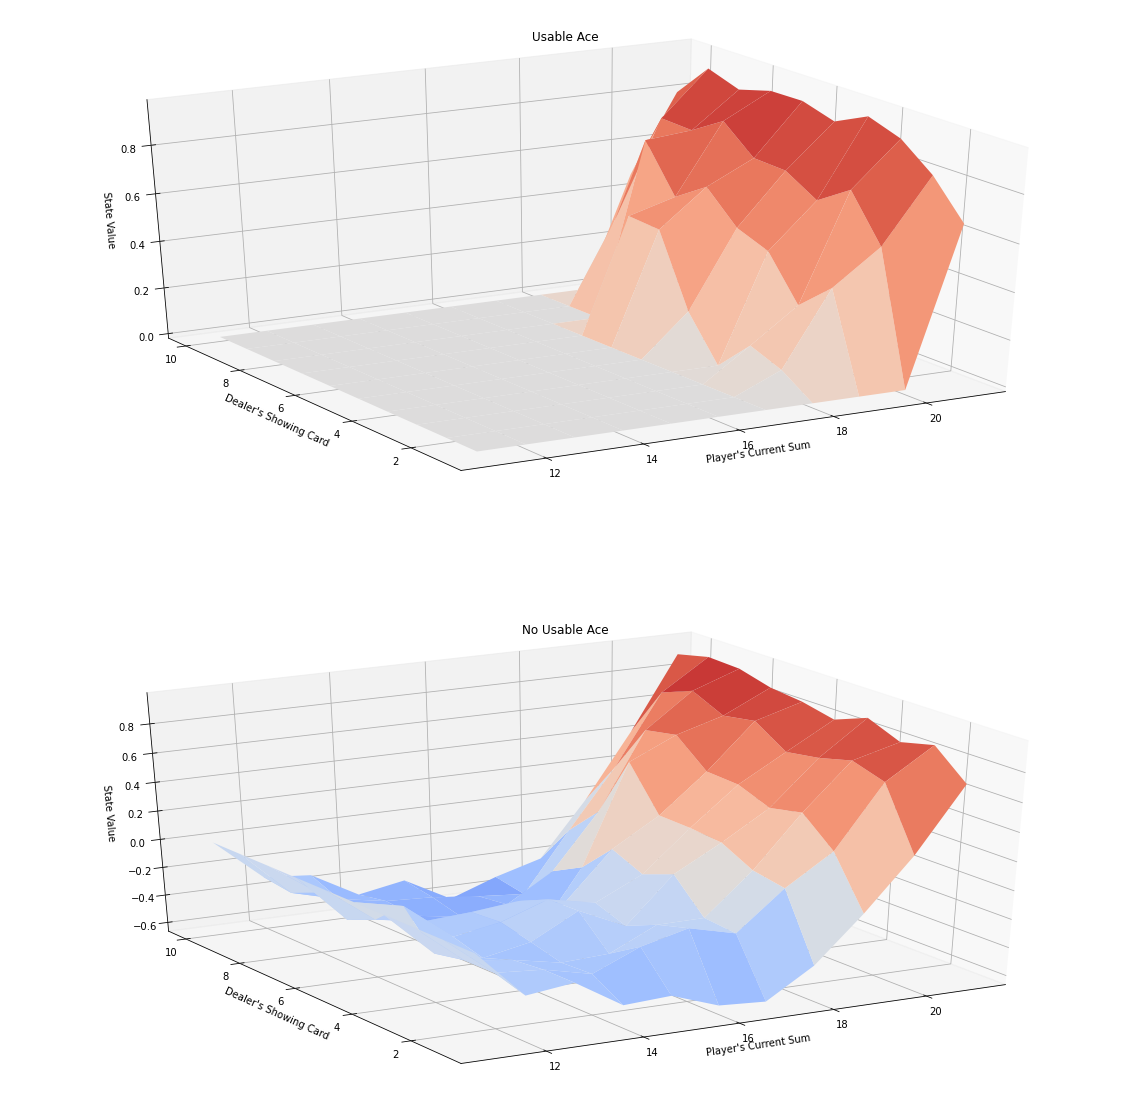

In [31]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

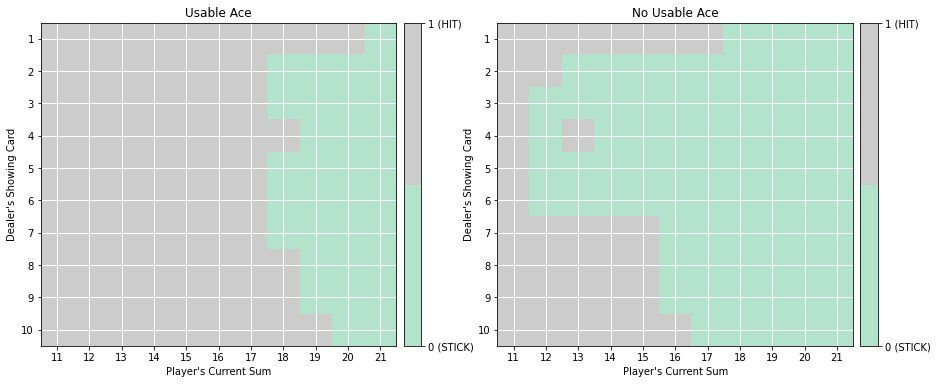

In [32]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)